In [13]:
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ensure reproducibility
tf.random.set_seed(42)

# output directories
os.makedirs("output/models", exist_ok=True)
os.makedirs("output/results", exist_ok=True)
os.makedirs("output/visualizations", exist_ok=True)

In [14]:
base_dir = Path("data/processed")

files = {
    "gossipcop_fake.csv": "fake",
    "gossipcop_real.csv": "real",
    "politifact_fake.csv": "fake",
    "politifact_real.csv": "real",
}

dfs = []
for f, label in files.items():
    df = pd.read_csv(base_dir / f)
    df["label"] = 0 if label == "fake" else 1  # 0=fake, 1=real
    dfs.append(df[["title", "label"]])

full_df = pd.concat(dfs, ignore_index=True)
print("✅ Combined dataset:", full_df.shape)
full_df.head()

✅ Combined dataset: (23196, 2)


,title,label
0,Did Miley Cyrus and Liam Hemsworth secretly ge...,0
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,0
2,Celebrities Join Tax March in Protest of Donal...,0
3,Cindy Crawford's daughter Kaia Gerber wears a ...,0
4,Full List of 2018 Oscar Nominations – Variety,0


In [15]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

full_df["clean_title"] = full_df["title"].apply(clean_text)
full_df.head()

,title,label,clean_title
0,Did Miley Cyrus and Liam Hemsworth secretly ge...,0,did miley cyrus and liam hemsworth secretly ge...
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,0,paris jackson cara delevingne enjoy night out ...
2,Celebrities Join Tax March in Protest of Donal...,0,celebrities join tax march in protest of donal...
3,Cindy Crawford's daughter Kaia Gerber wears a ...,0,cindy crawfords daughter kaia gerber wears a w...
4,Full List of 2018 Oscar Nominations – Variety,0,full list of 2018 oscar nominations variety


In [16]:
train_df, temp_df = train_test_split(full_df, test_size=0.3, stratify=full_df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 16237 | Val: 3479 | Test: 3480


In [17]:
MAX_VOCAB = 20000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_title"])

def tokenize_texts(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")

X_train = tokenize_texts(train_df["clean_title"])
X_val = tokenize_texts(val_df["clean_title"])
X_test = tokenize_texts(test_df["clean_title"])

y_train = np.array(train_df["label"])
y_val = np.array(val_df["label"])
y_test = np.array(test_df["label"])

print("✅ Tokenization done:", X_train.shape, X_val.shape, X_test.shape)

✅ Tokenization done: (16237, 50) (3479, 50) (3480, 50)


In [18]:
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D

EMBED_DIM = 128
FILTERS = 64
LSTM_UNITS = 64

model = Sequential([
    Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN),
    SpatialDropout1D(0.3),                          
    Conv1D(FILTERS, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(LSTM_UNITS, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/Users/nhuquynhtran/Downloads/Tensorflow Env (Latest)/tf219-env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1)
checkpoint_path = "output/models/cnn_lstm_model.h5"

mc = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[es, reduce_lr, mc],
    verbose=1
)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7674 - loss: 0.5284
Epoch 1: val_accuracy improved from -inf to 0.84248, saving model to output/models/cnn_lstm_model.h5


254/254 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.7675 - loss: 0.5282 - val_accuracy: 0.8425 - val_loss: 0.3803 - learning_rate: 0.0010
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8643 - loss: 0.3280
Epoch 2: val_accuracy did not improve from 0.84248
254/254 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.8644 - loss: 0.3279 - val_accuracy: 0.8393 - val_loss: 0.3845 - learning_rate: 0.0010
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9138 - loss: 0.2242
Epoch 3: val_accuracy did not improve from 0.84248
254/254 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.9139 - loss: 0.2240 - val_accuracy: 0.8295 - val_loss: 0.4592 - learning_rate: 3.0000e-04
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9303 - loss: 0.1842
Epoch 4: val_accuracy did not improve from 0.84248
254/254 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.9303 - loss: 0.1841 - val_accuracy: 0.8298 - val_loss: 0.4930 - learning_rate: 9.0000e-05


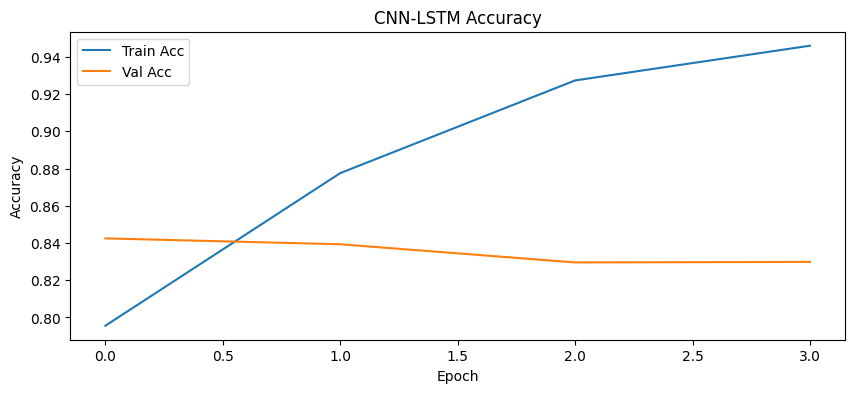

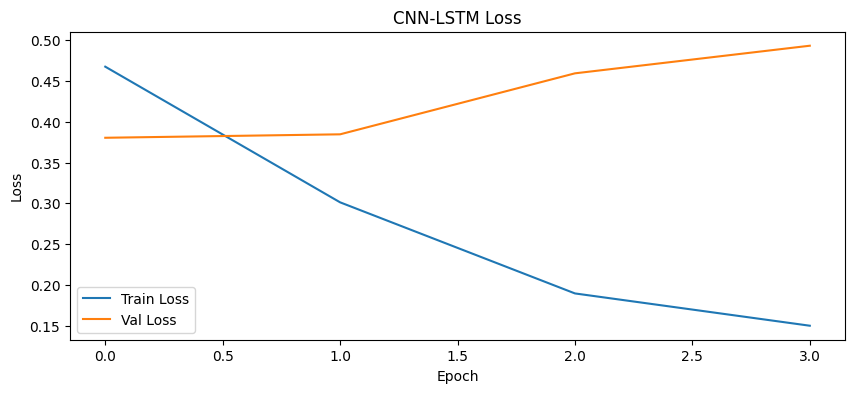

In [20]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("CNN-LSTM Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("output/visualizations/accuracy_curve.png")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("CNN-LSTM Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("output/visualizations/loss_curve.png")
plt.show()

In [21]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step
✅ Test Accuracy: 0.8509

Classification Report:
               precision    recall  f1-score   support

        Fake       0.81      0.53      0.64       864
        Real       0.86      0.96      0.91      2616

    accuracy                           0.85      3480
   macro avg       0.83      0.74      0.77      3480
weighted avg       0.85      0.85      0.84      3480



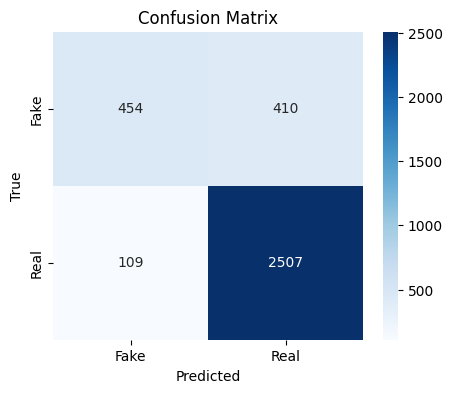

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("output/visualizations/confusion_matrix.png")
plt.show()

In [23]:
import pickle

# Model already saved via checkpoint
print("✅ Saved model to:", checkpoint_path)

# Save tokenizer
with open("output/models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Saved tokenizer.")

✅ Saved model to: output/models/cnn_lstm_model.h5
✅ Saved tokenizer.


In [24]:
def predict_text(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    pred = model.predict(padded)[0][0]
    label = "Real" if pred >= 0.5 else "Fake"
    return label, float(pred)

sample = "Breaking news: scientists found water on Mars!"
label, score = predict_text(sample)
print(f"Prediction: {label} ({score:.3f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Prediction: Fake (0.471)
